# NYC Taxi Fare Prediction

## Project Overview
The goal of this project is to predict NYC taxi fares based on trip distance, number of passengers, and pickup time. This notebook demonstrates a complete ML workflow including data preparation, feature engineering, model training, evaluation, and visualization.

## Dataset
The dataset contains 10K sample trips with columns:
- `pickup_datetime`: Trip start time
- `passenger_count`: Number of passengers
- `pickup_longitude` & `pickup_latitude`: Pickup location
- `dropoff_longitude` & `dropoff_latitude`: Dropoff location
- `fare_amount`: Fare in USD


In [38]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns




## Load Dataset
Load the CSV dataset and inspect the first few rows.


In [39]:
import pandas as pd

# Load CSV and parse datetime column
df = pd.read_csv("nyc_taxi_sample.csv", parse_dates=['pickup_datetime'])

# Preview first 5 rows
df.head()


,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount
0,2021-01-16 18:48:00,7.0,-73.867719,40.818749,-74.010928,40.791103,28.228590
1,2021-01-30 11:17:00,1.0,-73.885585,40.805949,-73.926843,40.819534,23.321019
2,2021-01-18 18:37:00,5.0,-73.971942,40.799390,-73.943449,40.698881,33.660549
3,2021-01-02 03:39:00,3.0,-73.853384,40.704131,-74.015449,40.640285,50.065749
4,2021-01-09 20:57:00,2.0,-73.801889,40.767783,-74.025280,40.658758,61.245938


## **Data Inspection**
Check dataset info, missing values, and basic statistics.


In [40]:
# Dataset shape and info
print("Dataset shape:", df.shape)
print("\nDataset info:")
print(df.info())

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Quick descriptive statistics
print("\nDataset statistics:")
print(df.describe())


Dataset shape: (10000, 7)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   pickup_datetime    10000 non-null  datetime64[ns]
 1   passenger_count    9970 non-null   float64       
 2   pickup_longitude   9970 non-null   float64       
 3   pickup_latitude    10000 non-null  float64       
 4   dropoff_longitude  10000 non-null  float64       
 5   dropoff_latitude   9970 non-null   float64       
 6   fare_amount        10000 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 547.0 KB
None

Missing values per column:
pickup_datetime       0
passenger_count      30
pickup_longitude     30
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude     30
fare_amount           0
dtype: int64

Dataset statistics:
                     pickup_datetime  passenger_count  pickup

## **Feature Engineering**
We extract additional features:
- Trip distance in km from pickup and dropoff coordinates
- Pickup hour and day of the week


In [41]:
import numpy as np

# Filter invalid rows
df = df[(df['fare_amount'] > 0) & (df['passenger_count'] > 0) & (df['passenger_count'] <= 6)]

# Haversine function to calculate distance in km
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

# Add trip distance column
df['trip_distance_km'] = haversine(df['pickup_latitude'], df['pickup_longitude'],
                                   df['dropoff_latitude'], df['dropoff_longitude'])

# Add hour of day
df['pickup_hour'] = df['pickup_datetime'].dt.hour

# Add day of week
df['pickup_dayofweek'] = df['pickup_datetime'].dt.dayofweek

# Preview cleaned data
df.head()


,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,trip_distance_km,pickup_hour,pickup_dayofweek
1,2021-01-30 11:17:00,1.0,-73.885585,40.805949,-73.926843,40.819534,23.321019,3.786552,11,5
2,2021-01-18 18:37:00,5.0,-73.971942,40.799390,-73.943449,40.698881,33.660549,11.430865,18,0
3,2021-01-02 03:39:00,3.0,-73.853384,40.704131,-74.015449,40.640285,50.065749,15.401659,3,5
4,2021-01-09 20:57:00,2.0,-73.801889,40.767783,-74.025280,40.658758,61.245938,22.393554,20,5
5,2021-01-21 16:56:00,2.0,-73.805040,40.640916,-73.989035,40.704461,57.089005,17.050242,16,3


Observation: Added 3 new columns: `trip_distance_km`, `pickup_hour`, `pickup_dayofweek`.


## Train-Test Split
We split the dataset into training (80%) and test (20%) sets.


In [42]:
# --- Drop rows with any null values ---
df = df.dropna()
# Select features and target
X = df[['trip_distance_km', 'passenger_count', 'pickup_hour', 'pickup_dayofweek']]
y = df['fare_amount']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Model 1: Linear Regression
We train a simple Linear Regression model to predict fare amounts.


In [43]:
# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test)

# Evaluate
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression RMSE:", rmse_lr)
print("Linear Regression R2:", r2_lr)


Linear Regression RMSE: 5.901642380173666
Linear Regression R2: 0.8241346345532783


Observation: Linear Regression achieved RMSE ≈ 5.90 and R² ≈ 0.83.


## Model 2: Random Forest Regressor
We train a Random Forest model to see if it improves performance.


In [44]:
# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest RMSE:", rmse_rf)
print("Random Forest R2:", r2_rf)


Random Forest RMSE: 6.28728604928931
Random Forest R2: 0.800399796451487


Observation: Random Forest achieved RMSE ≈ 6.28 and R² ≈ 0.80. Linear Regression slightly outperformed it here.


## Feature Importance (Random Forest)
Trip distance is the most important predictor.


In [45]:
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Feature Importances:\n", feature_importances)


Feature Importances:
 trip_distance_km    0.919198
pickup_hour         0.037548
pickup_dayofweek    0.022974
passenger_count     0.020280
dtype: float64


## Model Evaluation: Visualization
We compare both models using scatter plots and residuals.


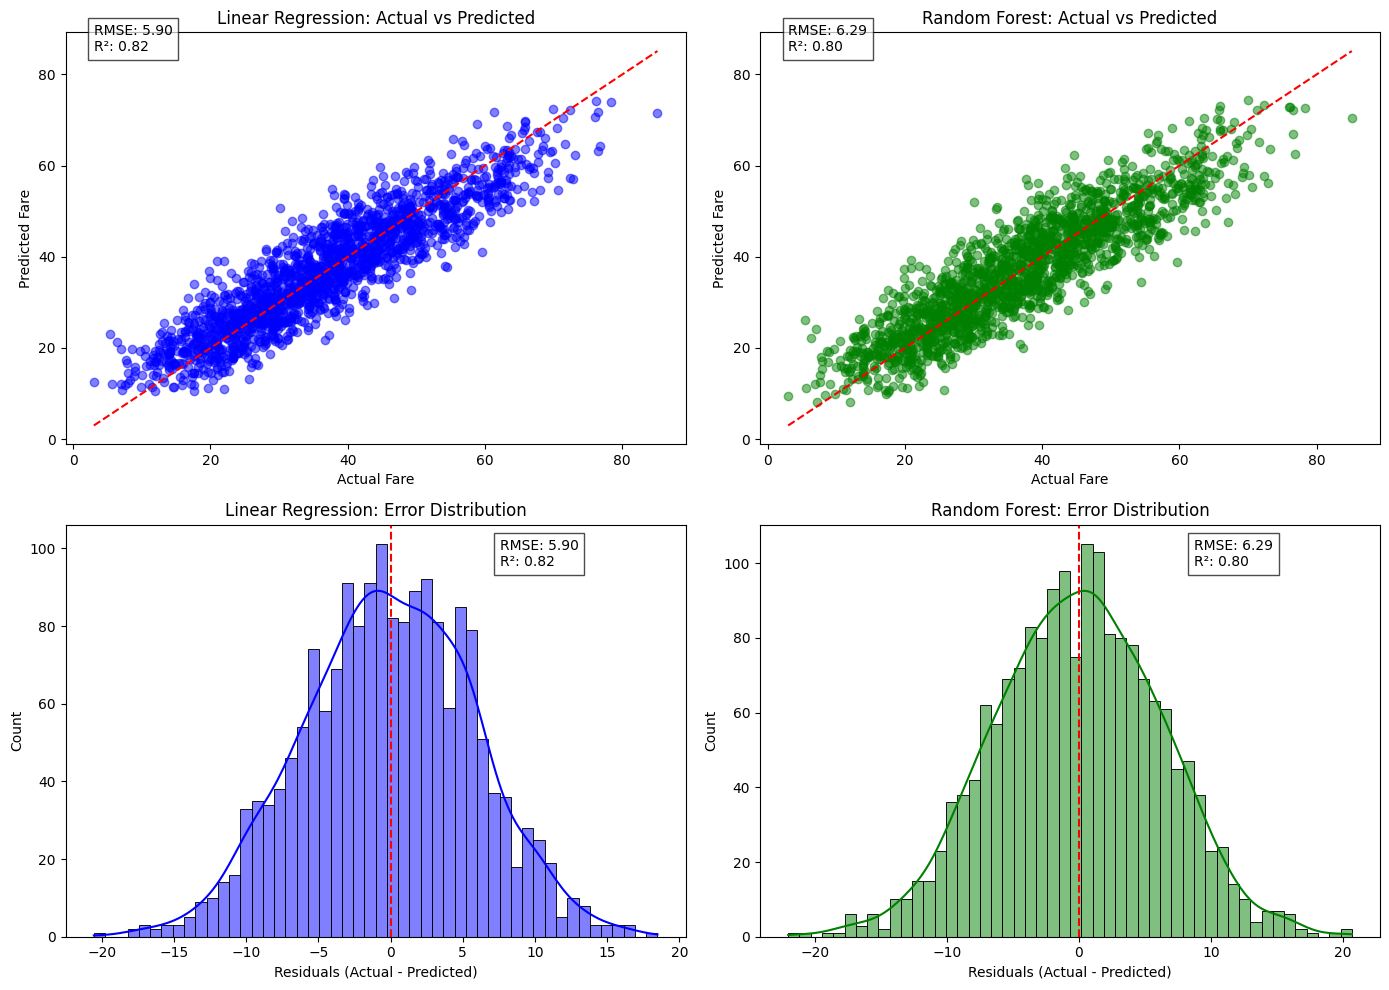

In [46]:
# Residuals
residuals_lr = y_test - y_pred_lr
residuals_rf = y_test - y_pred_rf

plt.figure(figsize=(14,10))

# 1. Linear Regression: Actual vs Predicted
plt.subplot(2,2,1)
plt.scatter(y_test, y_pred_lr, alpha=0.5, color="blue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Fare")
plt.ylabel("Predicted Fare")
plt.title("Linear Regression: Actual vs Predicted")
plt.text(y_test.min(), y_test.max(), f"RMSE: {rmse_lr:.2f}\nR²: {r2_lr:.2f}",
         fontsize=10, color="black", bbox=dict(facecolor="white", alpha=0.7))

# 2. Random Forest: Actual vs Predicted
plt.subplot(2,2,2)
plt.scatter(y_test, y_pred_rf, alpha=0.5, color="green")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Fare")
plt.ylabel("Predicted Fare")
plt.title("Random Forest: Actual vs Predicted")
plt.text(y_test.min(), y_test.max(), f"RMSE: {rmse_rf:.2f}\nR²: {r2_rf:.2f}",
         fontsize=10, color="black", bbox=dict(facecolor="white", alpha=0.7))

# 3. Linear Regression: Error Distribution
plt.subplot(2,2,3)
sns.histplot(residuals_lr, bins=50, kde=True, color="blue")
plt.axvline(0, color='r', linestyle='--')
plt.xlabel("Residuals (Actual - Predicted)")
plt.title("Linear Regression: Error Distribution")
plt.text(0.7, 0.9, f"RMSE: {rmse_lr:.2f}\nR²: {r2_lr:.2f}",
         transform=plt.gca().transAxes, fontsize=10,
         bbox=dict(facecolor="white", alpha=0.7))

# 4. Random Forest: Error Distribution
plt.subplot(2,2,4)
sns.histplot(residuals_rf, bins=50, kde=True, color="green")
plt.axvline(0, color='r', linestyle='--')
plt.xlabel("Residuals (Actual - Predicted)")
plt.title("Random Forest: Error Distribution")
plt.text(0.7, 0.9, f"RMSE: {rmse_rf:.2f}\nR²: {r2_rf:.2f}",
         transform=plt.gca().transAxes, fontsize=10,
         bbox=dict(facecolor="white", alpha=0.7))

plt.tight_layout()
plt.show()


## Model Performance Comparison Table


In [47]:
results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest"],
    "RMSE": [rmse_lr, rmse_rf],
    "R² Score": [r2_lr, r2_rf]
})

print("\nModel Performance Comparison:\n")
print(results.to_string(index=False))



Model Performance Comparison:

            Model     RMSE  R² Score
Linear Regression 5.901642  0.824135
    Random Forest 6.287286  0.800400


## Conclusion
- Linear Regression slightly outperformed Random Forest for this dataset.  
- Trip distance is the most important feature.  
- Both models are able to predict fare amounts with reasonable accuracy (R² > 0.8).  

